<a href="https://colab.research.google.com/github/AlexanderF048/GOIT_DS/blob/main/HW_4_DS_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')

#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})(1.0, 0.0, 0.0, 0.3)
sns.set(rc={'figure.facecolor': 'slategray'})

Mounted at /content/gdrive


Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('gdrive/My Drive/Data-science/bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

In [3]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)',
       'cnt'],
      dtype='object')

In [4]:
df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810
...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,10.486773
727,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,4.656485
728,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,3.725374
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372


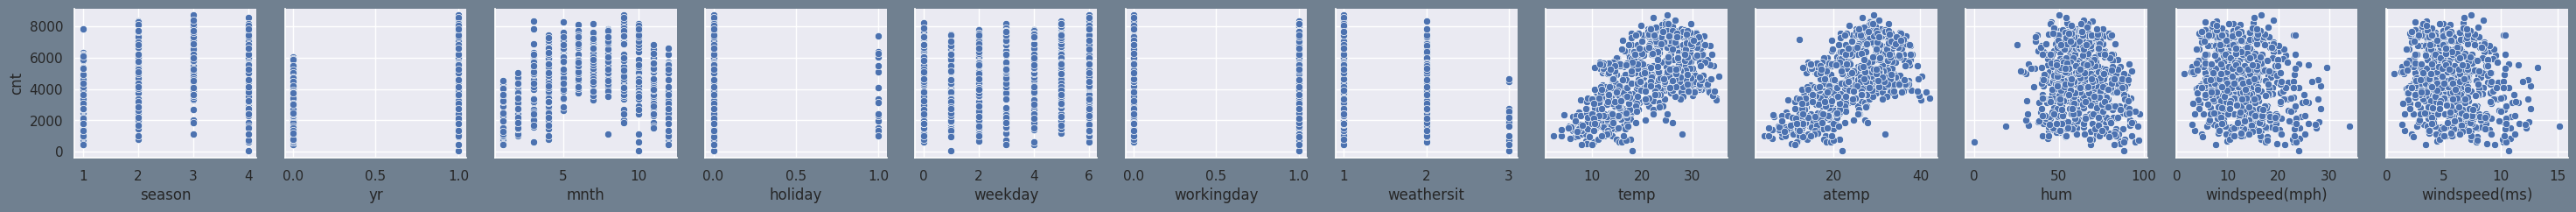

In [5]:
bikes = sns.PairGrid(df, y_vars=['cnt'], x_vars=[
    'season', 
    'yr', 
    'mnth',
    'holiday',
    'weekday', 
    'workingday', 
    'weathersit', 
    'temp', 
    'atemp', 
    'hum', 
    'windspeed(mph)', 
    'windspeed(ms)'
    ])
bikes.map(sns.scatterplot)

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?\
    ✅ Присутствует нелинейная зависимость
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно\
    ✅temp-atemp, hum, windspeed(mph-ms)

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

<Axes: >

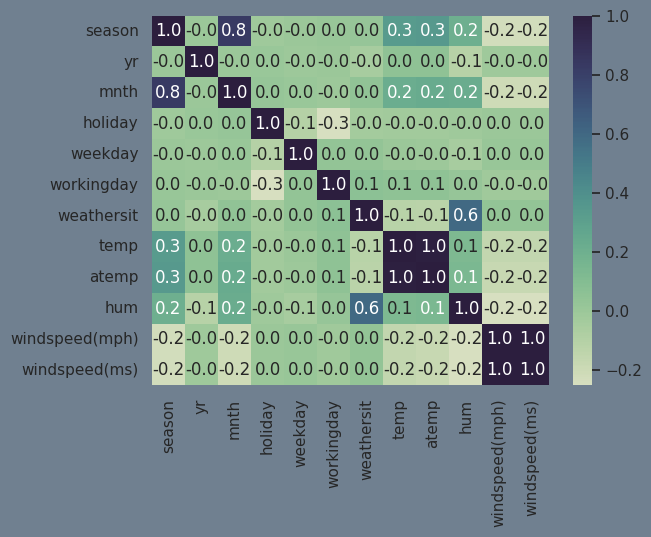

In [6]:
corr_df = df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']].dropna().corr()
print(corr_df)
sns.heatmap(corr_df, annot = True, fmt=".01f", cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))

In [7]:
corr_with_df = df.corrwith(df.cnt, axis=0, drop=False, method='pearson')
corr_with_df


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

In [8]:
df.iloc[:, :-1].corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


<Axes: >

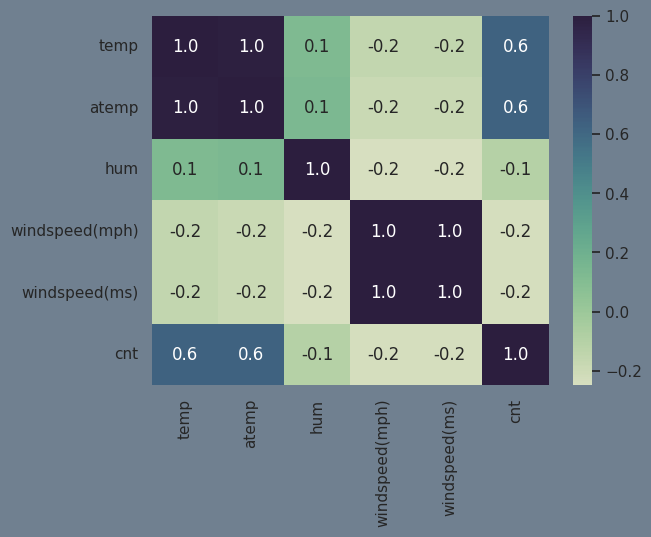

In [9]:
corr_df = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].dropna().corr()
print(corr_df)
sns.heatmap(corr_df, annot = True, fmt=".01f", cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [10]:
df[['temp','atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].mean()

temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [11]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [12]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
print(df_shuffled)
print(X)
print(y)

     season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
703       4   1    12        0        2           1           1  19.509153   
33        1   0     2        0        4           1           1   7.665237   
300       4   0    10        0        5           1           2  13.564153   
456       2   1     4        0        0           0           2  17.459153   
633       4   1     9        0        2           1           1  22.550000   
..      ...  ..   ...      ...      ...         ...         ...        ...   
71        1   0     3        0        0           0           1  15.758268   
106       2   0     4        0        0           0           1  18.723347   
270       4   0     9        0        3           1           2  26.035000   
435       1   1     3        0        0           0           1  14.831299   
102       2   0     4        0        3           1           2  16.912500   

        atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
7

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [13]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [14]:
regressor = LinearRegression().fit(X, y)
regressor.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

In [15]:
print('STANDARD VERSION Feauture/Weight:::::::::::::::')
print('--------------------------------------------')
for x,y in zip(df.columns, regressor.coef_):
  print(x,y)

STANDARD VERSION Feauture/Weight:::::::::::::::
--------------------------------------------
season 570.8637960129914
yr 1021.9653779400622
mnth -141.3017451148728
holiday -86.7593446245368
weekday 137.22506441350538
workingday 56.391881775973005
weathersit -330.2264620440312
temp 367.48373260182126
atemp 585.5493861188597
hum -145.61430569885857
windspeed(mph) 12457138390688.885
windspeed(ms) -12457138390887.346


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [16]:
from sklearn import linear_model

df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

lasso_regressor = linear_model.Lasso(alpha=0.1).fit(X, y)
print('LASSO VERSION Feauture/Weight:::::::::::::::')
print('--------------------------------------------')
for x,y in zip(df.columns, lasso_regressor.coef_):
  print(x,y)

LASSO VERSION Feauture/Weight:::::::::::::::
--------------------------------------------
season 565.3216570612018
yr 1020.2561015161349
mnth -133.89500587503778
holiday -86.66727917692955
weekday 138.21983421616665
workingday 55.87035675016136
weathersit -332.69555472955386
temp 377.3683235504604
atemp 575.6727820441071
hum -144.87124671813464
windspeed(mph) -198.10557751370823
windspeed(ms) -2.8284808432494093e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [17]:
from sklearn import linear_model

df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

ridge_regressor = linear_model.Ridge(alpha=0.1).fit(X, y)
print('RIDGE VERSION Feauture/Weight:::::::::::::::')
print('--------------------------------------------')
for x,y in zip(df.columns, ridge_regressor.coef_):
  print(x,y)

RIDGE VERSION Feauture/Weight:::::::::::::::
--------------------------------------------
season 565.5927961447981
yr 1020.2102053573418
mnth -134.2017935181863
holiday -86.69921614667157
weekday 138.323120109074
workingday 55.95017182416085
weathersit -332.6627869363585
temp 372.9090809742628
atemp 580.1125852260847
hum -145.01904705128803
windspeed(mph) -99.06044565794967
windspeed(ms) -99.0604463879806


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [18]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
  lasso_regressor = linear_model.Lasso(alpha=alpha).fit(X, y)
  coefs_lasso.append(lasso_regressor.coef_)

  ridge_regressor = linear_model.Ridge(alpha=alpha).fit(X, y)
  coefs_ridge.append(ridge_regressor.coef_)

    
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

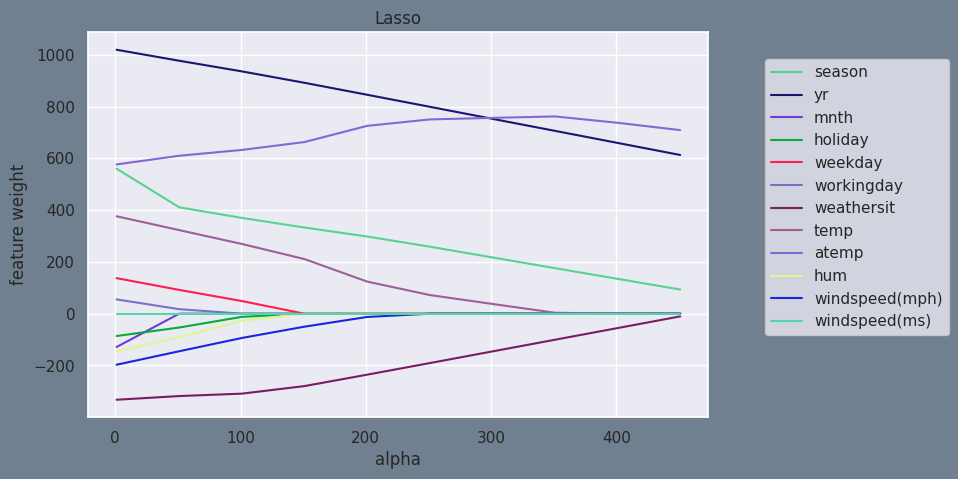

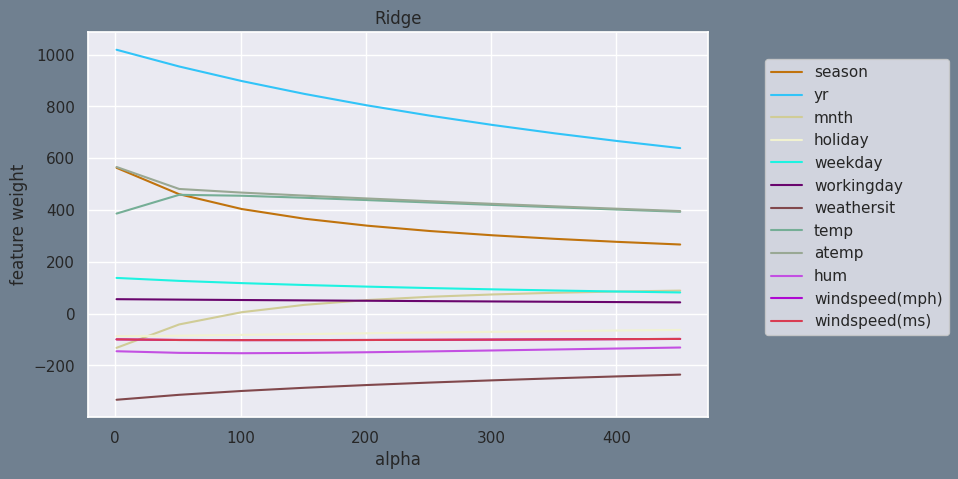

In [19]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
✅Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит. ❌ Без понятия...
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$. ✅ Можно
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков? ✅Lasso

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [72]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [44]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(cv=3, alphas=alphas, random_state=0).fit(X, y)

In [102]:
print('---------------------------------------')
print(regressor.alpha_)
print('---------------------------------------')
print(regressor.alphas_)
print('---------------------------------------')
print(regressor.coef_)
print('---------------------------------------')
print(regressor.mse_path_)

---------------------------------------
6
---------------------------------------
[96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]
---------------------------------------
[ 5.32018983e+02  1.01506022e+03 -1.00039526e+02 -8.32939599e+01
  1.32504465e+02  5.15570856e+01 -3.30559857e+02  3.70679855e+02
  5.81396931e+02 -1.40007406e+02 -1.91771408e+02 -2.68547023e-08]
---------------------------------------
[[830768.68693702 919721.93589263 805481.54522903]
 [822965.9041311  911867.54470864 804343.02766964]
 [815129.08593972 903855.55058088 803483.74706927]
 [807667.98224742 896148.95236924 802906.09265381]
 [800137.23263318 888747.72399201 801974.9311743 ]
 [793005.6616591  881651.8631318  800937.92121214]
 [786275.36724172 874861.36810104 799342.37031522]
 [779946.35004807 868376.23749144 798151.12777192]
 [774018.6100807  862196.47012638 797363.63293845]
 [768492.14733962 856322.06502308 796979.89551936]
 [763366.96182482 850359.8722302  796999.92588656]
 [758643.05353631 8

❌

96    851990.722686
91    846392.158836
86    840822.794530
81    835574.342423
76    830286.629266
71    825198.482001
66    820159.701886
61    815491.238437
56    811192.904382
51    807264.702627
46    803575.586647
41    800211.247462
36    797217.569993
31    794594.560667
26    792342.195766
21    789464.663203
16    786750.840839
11    783634.377291
6     781531.090820
1     785055.146787
dtype: float64
<class 'numpy.ndarray'>


RuntimeError: ignored

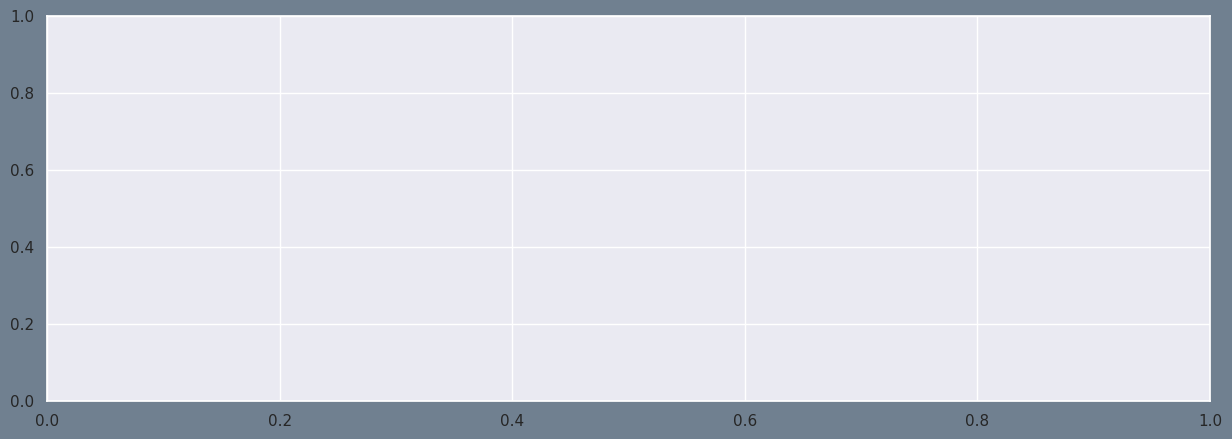

In [111]:
df_data = pd.DataFrame(data=regressor.mse_path_, index=regressor.alphas_)
print(df_data.mean(axis=1))

np_data = np.array(regressor.mse_path_) + np.array(regressor.alphas_).mean(axis=0)
print(type(np_data))
create_plot(np_data, 'title', 'xlabel', 'ylabel', figsize=None)

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [51]:
print('Alphas with minimum MSE:')
for alpha, mse in zip(regressor.alphas_, regressor.mse_path_):
    print(f'Alpha = {alpha}, MSE = {mse}')

Alphas with minimum MSE:
Alpha = 96, MSE = [830768.68693702 919721.93589263 805481.54522903]
Alpha = 91, MSE = [822965.9041311  911867.54470864 804343.02766964]
Alpha = 86, MSE = [815129.08593972 903855.55058088 803483.74706927]
Alpha = 81, MSE = [807667.98224742 896148.95236924 802906.09265381]
Alpha = 76, MSE = [800137.23263318 888747.72399201 801974.9311743 ]
Alpha = 71, MSE = [793005.6616591  881651.8631318  800937.92121214]
Alpha = 66, MSE = [786275.36724172 874861.36810104 799342.37031522]
Alpha = 61, MSE = [779946.35004807 868376.23749144 798151.12777192]
Alpha = 56, MSE = [774018.6100807  862196.47012638 797363.63293845]
Alpha = 51, MSE = [768492.14733962 856322.06502308 796979.89551936]
Alpha = 46, MSE = [763366.96182482 850359.8722302  796999.92588656]
Alpha = 41, MSE = [758643.05353631 844566.95589129 797423.73295863]
Alpha = 36, MSE = [754320.42247408 839080.96310802 798251.32439694]
Alpha = 31, MSE = [750399.06863813 833901.906581   799482.70678255]
Alpha = 26, MSE = [7468

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [ ]:
# ???

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
# ???

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [ ]:
# ???

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.